# read preprocessing

In [ ]:
# read trimming

# phenol/chloroform extracted DRT2 RNPs. P12_A5 = WT. P12_A6 = YCDD>YCAA mutant. P12_A7 = WT treated with DRB1.
# Sequenced on a MiSeq, R1 = 300bp.
! bash
! conda activate bioconda2
! cd OTTR_reads/
! mkdir Trimmed
! for input in P12_A*.fastq.gz; do out=Trimmed/$(echo $input | sed 's/fastq\.gz/fastq/'); cutadapt --trim-n -q 20 -m 20 -a ATCGGTTCGAGATGGCTCG -g ^NNNNNR -o $out $input; done



# phenol/chloroform extracted DRT2 RNPs where the PBS is a library of variants. P7_H11.
# Sequenced on a MiSeq, R1 = 10 bp (discarded), R2 = 290 bp.
! cutadapt --trim-n -q 20 -m 20 -a GYNNNNNCTGTCTCTTATACACATCTGACGCTGCCGACGA -g ^CGAGCCATCTCGAACCGATT -o Trimmed/P7_H11_S1_R2_001.fastq P7_H11_S1_R2_001.fastq.gz
! cd Trimmed/
! cutadapt -g ^CGAGCCATCTCGAACCGATT P7_H11_S1_R2_001.fastq > P7_H11_S1_R2_001_retrim.fastq
! cd ../

# DRT2 RNP incubated with 16 uM dNTPs, then phenol/chloroform extracted. P7_H12.
# Sequenced on a MiSeq, R1 = 10 bp (discarded), R2 = 290 bp.
! cutadapt --trim-n -q 20 -m 20 -g CGAGCCATCTCGAACCGATT -o Trimmed/H12_trim1.fastq P7_H12_S2_R2_001.fastq.gz 
! cd Trimmed/
! cutadapt -g CGAGCCATCTCGAACCGATT -o H12_trim2.fastq H12_trim1.fastq
! cutadapt -a CGAGCCATCTCGAACCGATT -o H12_trim3.fastq H12_trim2.fastq
! cutadapt -a GYNNNNNCTGTCTCTTATACACATCT -m 20 -o H12_trim4.fastq H12_trim3.fastq
! cd ../


# DRT2 RNP incubated with 16 uM dNTPs, then RNA removed by alkaline hydrolysis, before phenol/chloroform extraction. P4_H11.
# Sequenced on a MiSeq, R1 = 300 bp.
! cutadapt --trim-n -q 20 -m 20 -a AATCGGTTCGAGATGGCTCG -o Trimmed/P4_H11_S2_R1_001.fastq P4_H11_S2_R1_001.fastq.gz
! cd Trimmed
! cutadapt -a AATCGGTTCGAGATGGCTCG -o H11_trim2.fastq P4_H11_S2_R1_001.fastq
! cutadapt -a AATCGGTTCGAGATGGCTCG -m 8 -o H11_trim3.fastq H11_trim2.fastq 
! cutadapt -g ^NNNNNRC  -o H11_trim4.fastq H11_trim3.fastq 
! cd ../


# read mapping
! cd sam/
! bwa index pLG128.fasta
! bwa mem pLG128.fasta ../Trimmed/P7_H11_S1_R2_001_retrim.fastq > H11.sam
# n.b. pLG128 is the in-house name for the plasmid pLG010 available on Addgene
# all other reads were mapped using the Geneious read mapper, but similar results can be obtained using bwa mem as above

# read analysis (in python)

In [28]:
# Run in bioconda environment

#Import helpful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['ytick.major.width'] = 0.5

matplotlib.rcParams['patch.force_edgecolor'] = True
matplotlib.rcParams['patch.linewidth'] = 0.5


#Packages for sequence parsing
from Bio.Seq import Seq
import pysam
import logomaker

#Some useful colors for the sequence logos

logo_colorscheme = {
    'A': "#C63F59",
    'C': "#B0492E",
    'G': "#F5D9AF",
    'T': "#E686AC"
}

hanpink = "#DC3860"
hanpink_dark = "#C63F59"
hanpink_light = "#F1617A"
hanpink_lightest = "#E686AC"
hanpinkpalette = [hanpink_dark, hanpink, hanpink_light, hanpink_lightest]

darkgrey = "#737880"
midgrey = "#949598"
lightgrey = "#C8CECE"
lightestgrey = "#DBDAD5"
greypalette = [darkgrey, midgrey, lightgrey, lightestgrey]
drtpalette = ["#B0492E", "#EB6E4A", "#E39625", "#F5D9AF"]


# Figure 4D

In [24]:
# this cell creates a frequency matrix for plotting for the experiment comparing WT DRT RNPs (-/+ DBR1) to YCAA RNPs

def matrix_from_bam(bampath, logofrom = 263, logolength=30):
    samfile = pysam.AlignmentFile(bampath, "rb")
    n=0
    matrix = {'A':np.zeros(logolength),'C':np.zeros(logolength), 'G':np.zeros(logolength), 'T':np.zeros(logolength)}
    primers = []

    for read in samfile.fetch(contig='pLG128',start=480,stop=500): # fetch reads mapping to end of ncRNA
        if read.query_length < 270: # just take reads spanning full ncRNA
            continue
        if not read.is_forward: #discard any reverse reads (only 0.09%)
            continue
        UMI = read.seq[0:6]

        n+=1
        try:
            print_from = read.get_reference_positions().index(logofrom + 227)
        except:
            continue
        if read.seq[-1] == 'A': # for this particular experiment, the ddA tail added by BoMoC during sequencing was not trimmed. Do this now.
            sequence = read.seq[print_from:-1]
        else:
            sequence = read.seq[print_from:]
        for i,x in enumerate(sequence):
            if i >= logolength:
                continue
            matrix[x][i]+=1
        
        primers.append(sequence)
    return matrix, primers


def freq_matrix_from_seq_list(seq_list, logolength=10, normalize = False):
    matrix = {'A':np.zeros(logolength),'C':np.zeros(logolength), 'G':np.zeros(logolength), 'T':np.zeros(logolength)}
    totalcounts = 0
    for seq in seq_list:
        totalcounts +=1
        for i,b in enumerate(seq):
            if i >= logolength:
                continue
            if b == '_': # used to notate balnk:
                continue
            matrix[b][i]+=1
    if normalize:
        matrix_norm = {k:v/totalcounts*100 for (k,v) in matrix.items()}
        return matrix_norm
    else:
        return matrix

bampaths = ["OTTR_reads/sam/A5_to_LG128_geneious.bam",
            "OTTR_reads/sam/A6_to_LG128_geneious.bam",
            "OTTR_reads/sam/A7_to_LG128_geneious.bam"]

matrices = [matrix_from_bam(path, logofrom=268, logolength=19) for path in bampaths]

In [25]:
# this cell parses the primer-binding site mutant library. It creates the list "pairs" where each member of the list is a tuple of the PBS sequence and the linked primer sequence.
# it also applies some filters so that only the really good reads are used.

good_reads = 0
all_reads = 0
pysam.sort("-o", "tmp.bam", 'OTTR_reads/sam/H11.sam')
pysam.index("tmp.bam")
samfile = pysam.AlignmentFile('tmp.bam', 'rb')

pairs = []

for read in samfile.fetch(contig=samfile.references[0],start=480,stop=500): # fetch reads mapping to end of ncRNA
    all_reads += 1
    if read.is_forward: #discard any "reverse" reads. This sequencing run used read 2, not read 1, so "read.is_forward" means we don't want it
        continue
    if read.query_length != 270: # this is the maximum readlength after adapter trimming, and means most reads should correspond to the full ncRNA
        continue

    reference_positions = read.get_reference_positions()
    if not ((285 in reference_positions) and (400 in reference_positions) and (450 in reference_positions)): # just checking that several positions throughout the ncRNA are mapped
        continue

    try:
        PBS_start = reference_positions.index(367)
        PBS_end = reference_positions.index(375)
        if PBS_end-PBS_start != 8:
            continue #avoid indels in PBS

        test_sequence_position = reference_positions.index(320)
        if read.query_sequence[test_sequence_position:test_sequence_position+20] != 'TTGGATGATATTCATAATTG': # check that the read is sensible and aligned correctly
            continue

        PBS_seq = read.query_sequence[PBS_start:PBS_end+1]

        if read.query_sequence[PBS_start-10:PBS_start] != 'ACATTATACA' or read.query_sequence[PBS_end+1:PBS_end+11] != 'ACATTTGCGG': # check that the sequence around the PBS is perfect
            continue

        PBS_revcomp = str(Seq(PBS_seq).reverse_complement())
        primer_start = reference_positions.index(505) #actually the base before the primer
        if read.query_sequence[primer_start-10:primer_start] != 'TCCGGTTTTG': #the sequence before the primer should be correct
            continue
        primer_seq = read.query_sequence[primer_start:]
        UMI=read.seq[0:6]
    except:
        continue

    good_reads+=1
    primer_length = len(primer_seq)
    pairs.append((PBS_seq, primer_seq))

print(good_reads, all_reads)

109076 210615


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


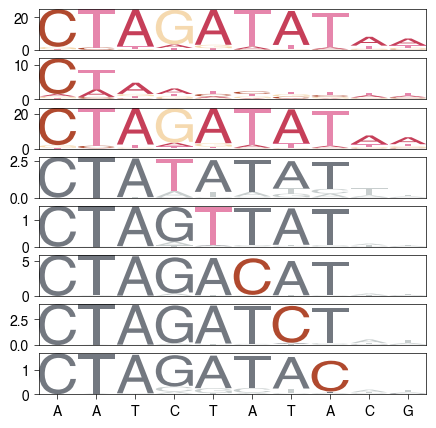

In [29]:
# YCAA experiment, and select examples from the PBS library, for main figure

fig, axs = plt.subplots(nrows=8, figsize=(5,5))


WTpbs = 'GCATATCTA'

for i in range(8):
        if i > 2:
            query_pbs = ['GCATATATA','GCATAACTA', 'GCATGTCTA','GCAGATCTA','GCGTATCTA'][i-3] # the list of PBS mutants chosen for the main figure
            primers = [p[1] for p in pairs if p[0]==query_pbs] 
        else:
            primers = [p[10:] for p in matrices[i][1] if len(p)>9]
        
        matrix = freq_matrix_from_seq_list(primers, logolength=10)
        matrix = {k:v/1000 for (k,v) in matrix.items()}

        ax=axs[i]
        
        if i < 3:
            logo = logomaker.Logo(pd.DataFrame(matrix), ax=ax, color_scheme=logo_colorscheme, font_name='Helvetica')
        else:
            logo = logomaker.Logo(pd.DataFrame(matrix), ax=ax, color_scheme=greypalette[2], font_name='Helvetica')
            logo.style_glyphs_in_sequence(sequence='CTAGATATGC', color=greypalette[0])
            logo.style_single_glyph(p=[3,4,5,6,7][i-3],c='TTCCC'[i-3],color=logo_colorscheme['TTCCC'[i-3]])
        ax.set_xticks(range(1+len(WTpbs)))
        ax.get_xaxis().set_visible(False)
axs[-1].get_xaxis().set_visible(True)   
axs[-1].set_xticklabels('A'+WTpbs[::-1])

plt.savefig("Fig4D.pdf", transparent=True)

# Fig S6B

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


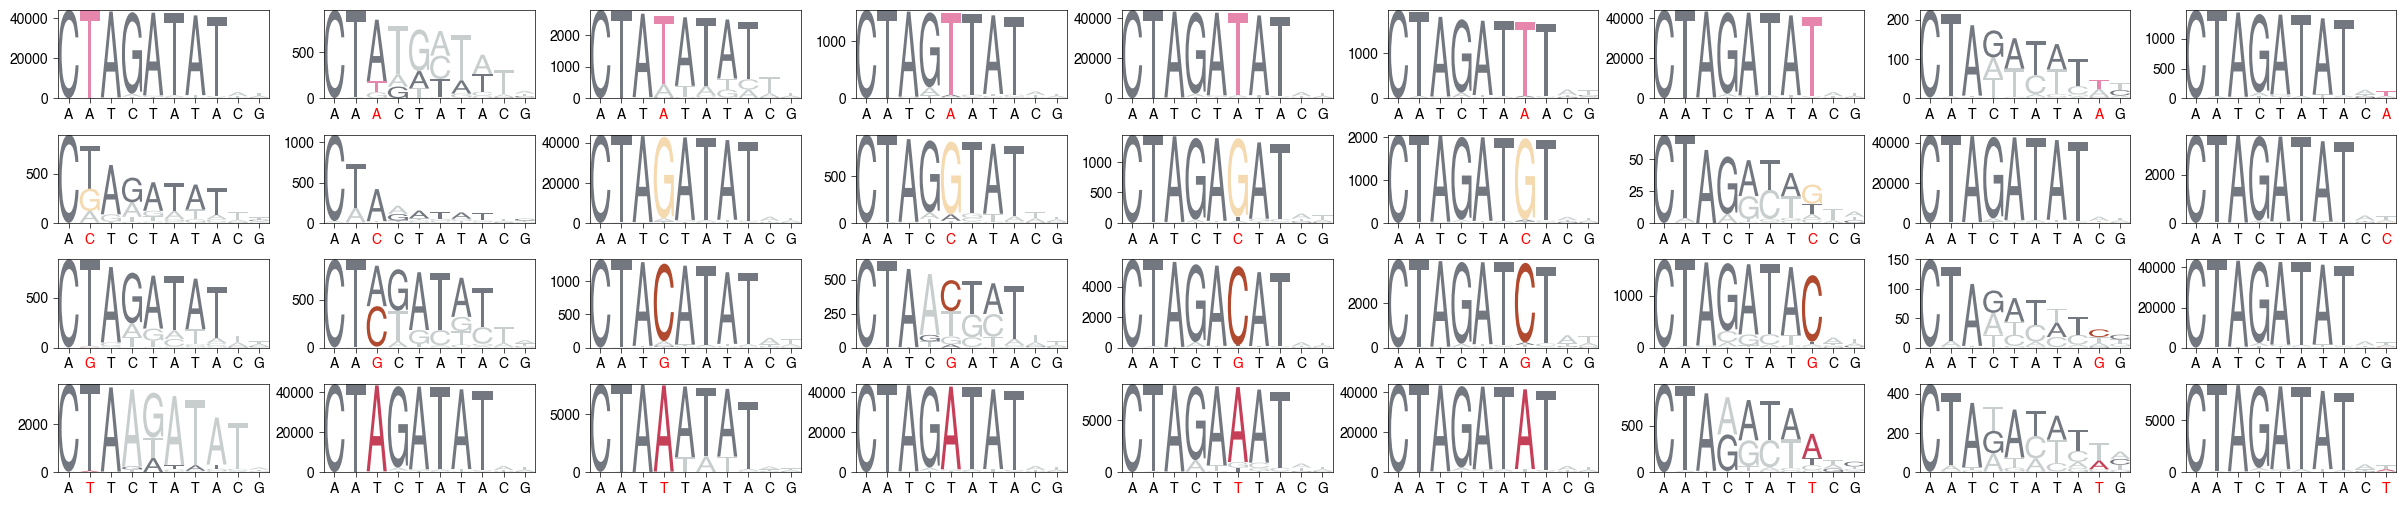

In [30]:
fig, axs = plt.subplots(nrows=4, ncols=9,figsize=(24,5))

WTpbs = 'GCATATCTA'
for i in range(9):
    for j in range(4):
        pbs = WTpbs[0:i] + 'ACGT'[j] + WTpbs[i+1:]
        if 'ACGT'[j] == WTpbs[i]:
            WT=True
        else:
            WT=False
        primers = [p[1] for p in pairs if p[0]==pbs]
        matrix = freq_matrix_from_seq_list(primers, normalize=False)
        ax=axs[j,8-i]
        logo = logomaker.Logo(pd.DataFrame(matrix), ax=ax, color_scheme=greypalette[2], font_name='Helvetica')
        logo.style_glyphs_in_sequence(sequence='CTAGATATGC', color=greypalette[0])
        logo.style_single_glyph(p=9-i,c='TGCA'[j],color=logo_colorscheme['TGCA'[j]])
        ax.set_xticks(range(1+len(pbs)))
        ax.set_xticklabels('A'+pbs[::-1])
        if WT:
            ax.get_xticklabels()[9-i].set_fontweight('heavy')
        else:
            ax.get_xticklabels()[9-i].set_color('r')

fig.tight_layout(pad=0.5)
plt.savefig("FigS6B.pdf", transparent=True)

# Fig S6C

In [31]:
samfile = pysam.AlignmentFile('OTTR_reads/sam/H12_trim4_to_pLG128.bam', "rb")
samfile_OH = pysam.AlignmentFile('OTTR_reads/sam/H11_trim4_to_pLG128.bam', "rb")

n=0
max_length = 30
primers_dNTPs = []
pad  = 7

sams = [(samfile,'R2'),(samfile_OH,'R1')] # the no-OH sample dervies from Read 1 data, the +OH sample derives from Read 2 data
outs = [[],[]]

# For this experiment, because dNTPs were added, there's quite a bit ccDNA around, which can either map to the end of the ncRNA (which it is linked to), or to the reverse complement of the template region.
# We want to visualize the reads corresponding to the 3' end of the RNA. These either map in forward orientation to 3' end of RNA (if read 1), or in reverse orientation to the PBS (if read 1).
# (and map the other way around if read 2 data)

for i, (samfile, readdir) in enumerate(sams):
    for read in samfile.fetch(contig='pLG128'):
        if (read.is_reverse and readdir=='R2') or (read.is_forward and readdir=='R1'):
            # get plus-strand reads mapping to the end of the ncRNA
            try:
                primer_start = read.get_reference_positions().index(508)
            except:
                continue
            sequence = read.seq
        else:
            # get minus-strand reads mapping to the PBS
            try:
                primer_start = read.get_reference_positions().index(373)
            except:
                continue
            sequence = str(Seq(read.seq).reverse_complement())
            primer_start = len(sequence) - primer_start - 1

        print_from = primer_start - pad
        if print_from < 0:
            padding = '_'*(print_from * -1)
            outs[i].append(padding+sequence[0:max_length+print_from])
        else:
            outs[i].append(sequence[print_from:print_from+max_length])

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


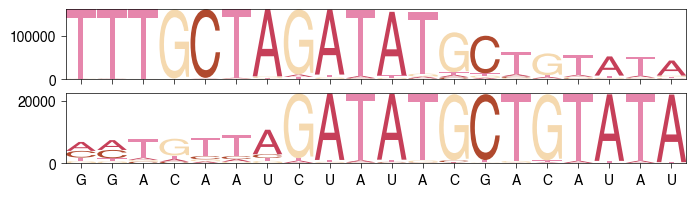

In [34]:
fig, axs = plt.subplots(figsize=(8,len(outs)),nrows=len(outs),sharex=True)
for i,out in enumerate(outs):
    plotme=freq_matrix_from_seq_list(out, logolength=20)
    logomaker.Logo(pd.DataFrame(plotme), ax=axs[i], color_scheme=logo_colorscheme, font_name='Helvetica')
    axs[i].set_xticks(range(20))
axs[-1].set_xticklabels('GGACAAUCUAUACGACAUAU')
plt.savefig("FigS6C.pdf", transparent=True)

# Figure 4G

/Users/maxwilkinson/opt/anaconda3/envs/bioconda2/lib/python3.9/site-packages/Bio/PDB/PDBParser.py:388: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 7771
  warnings.warn(
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


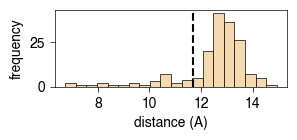

In [35]:
# plot the distribution of P-O3' distances in RNA. Using the DRT2 RNP resting state itself to derive these distributions. It has a good mix of A-form helices and other linkers, so should give a reasonably representative distribution.

from Bio.PDB import *
parser = PDBParser()
structure = parser.get_structure('DRT2', 'DRT2rnp.pdb')
Ps = []
Os = []
indices = []

for model in structure:
    for residue in model['R']:
        try:
            Ps.append(np.array(residue['P'].get_coord()))
            Os.append(np.array(residue["O3'"].get_coord()))
            indices.append(residue.get_id()[1])
        except:
            continue
Ps = np.array(Ps)
Os = np.array(Os)
indices = np.array(indices)

fullPs = np.zeros((280,3))
for n,index in enumerate(indices):
    fullPs[index,:] = Ps[n]
fullPs = np.where(fullPs==0, np.nan, fullPs) # inserting nans where the chain breaks, so we don't measure distances across chain breaks.

fullOs = np.zeros((280,3))
for n,index in enumerate(indices):
    fullOs[index,:] = Os[n]
fullOs = np.where(fullOs==0, np.nan, fullOs) # ditto

distances = []
for i in range(277):
    distances.append(np.sqrt(((fullPs[i+3] - fullOs[i])**2).sum())) # get all distances between 3'OHs and phosphate 2 bases away

fig,ax = plt.subplots(figsize=(3,1))
ax.hist(distances,bins=20,color=drtpalette[3])
ax.axvline(11.7, ls='--', c='k') # to indicate the observed distance beween the primer 5'P and C278 3'O

ax.set_ylabel('frequency')
ax.set_xlabel('distance (A)')
plt.savefig("Fig4G.pdf", transparent=True)